In [3]:
from docx import Document
import pandas as pd
import os

# 1. 加载 DOCX 文件
docx_path = "C:/Users/15959/Desktop/CDT505/1-s2.0-S0960852424010393-mmc1.docx"  # 替换为你的文件路径
doc = Document(docx_path)

# 2. 找到 Table S1（假设是第一个表格）
# 如果 DOCX 包含多个表格，可能需要调整代码，我会教你怎么检查
table = doc.tables[0]  # 假设 Table S1 是第一个表格

# 3. 提取表格数据
data = []
for row in table.rows:
    row_data = [cell.text.strip() for cell in row.cells]
    data.append(row_data)

# 4. 转换为 pandas DataFrame
# 假设第一行是表头
headers = data[0]
rows = data[1:]  # 跳过表头
df = pd.DataFrame(rows, columns=headers)

# 5. 清理列名（去除换行符、空格等）
df.columns = [col.replace('\n', ' ').strip() for col in df.columns]

# 6. 保存为 CSV
output_dir = "extracted_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

csv_path = os.path.join(output_dir, "table_s1.csv")
df.to_csv(csv_path, index=False)
print(f"数据已保存到：{csv_path}")

# 7. 查看前几行，确认提取是否正确
print("\n前5行数据：")
print(df.head())

# 8. 检查数据信息
print("\n数据信息：")
print(df.info())

数据已保存到：extracted_data\table_s1.csv

前5行数据：
  Time (day)   C/N Moisture (%) Air (L·kg-1 DM·min-1)   pH T (℃)  \
0          1  21.0         57.5                   0.2  4.1  37.8   
1          7  21.0         57.5                   0.2  4.1  48.7   
2         14  21.0         57.5                   0.2  7.6  53.5   
3         21  21.0         57.5                   0.2  7.1  51.5   
4         29  21.0         57.5                   0.2  8.1  32.1   

  NH4+ (g·kg-1 DM) NO3- (mg·kg-1 DM) NH3 (g·kg-1 DM) N20 (mg·kg-1 DM)  \
0           0.3267             29.56               0            39.42   
1            0.703             49.26          0.2796           925.17   
2           0.7426             39.41          2.4086          1382.31   
3           0.5545             78.82          2.8387          1436.73   
4           0.4752            108.37          3.0108          1447.62   

  EC (ms·cm-1) GI (%) CH4 (mg·kg-1 DM) GWP (g·kg-1 DM)  
0          2.2    5.6            53.85           13.

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import warnings

# 忽略特定警告
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 创建输出目录
if not os.path.exists('cleaned_data'):
    os.makedirs('cleaned_data')

print("===== 1. 数据加载与基本处理 =====")
# 加载数据
csv_path = 'C:/Users/15959/anaconda test/extracted_data/table_s1.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"文件 {csv_path} 不存在，请检查路径！")
df = pd.read_csv(csv_path)
print("\n初始列名：")
print(df.columns.tolist())

# 转换为数值型
numeric_cols = ['Time (day)', 'C/N', 'Moisture (%)', 'Air (L·kg-1 DM·min-1)', 
                'T (℃)', 'NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 处理缺失值
df.replace('/', pd.NA, inplace=True)
df.drop(columns=['GI (%)', 'EC (ms·cm-1)'], inplace=True, errors='ignore')

print("\n===== 2. 缺失值处理 =====")
# 检查初始缺失值
print("\n初始缺失值：")
print(df[['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)']].isna().sum())

# 组内线性插值
df[['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)']] = df.groupby(
    ['C/N', 'Moisture (%)', 'Air (L·kg-1 DM·min-1)']
)[['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)']].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)

# 用全局中位数填充剩余缺失值
for col in ['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)']:
    df[col] = df[col].fillna(df[col].median())

# 检查插值后缺失值
print("\n插值和填充后的缺失值：")
print(df[['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)']].isna().sum())

# 特征选择
core_columns = ['Time (day)', 'C/N', 'Moisture (%)', 'Air (L·kg-1 DM·min-1)', 
                'T (℃)', 'NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)']
df = df[core_columns]

# 处理 C/N 缺失值
print("\nC/N 列的缺失值：")
print(df['C/N'].isna().sum())
df['C/N'] = df['C/N'].fillna(df['C/N'].mode()[0])

print("\n===== 3. 异常值处理 =====")
# 修复版GWP上限处理 - 先直接对整个数据集应用上限
print("\n应用GWP上限(100)前的统计：")
print(df['GWP (g·kg-1 DM)'].describe())

# 首先记录超过阈值的GWP值
gwp_outliers = df[df['GWP (g·kg-1 DM)'] > 100].copy()
print(f"\n发现 {len(gwp_outliers)} 个 GWP 值 > 100")

# 计算每个实验组内GWP<=100的中值，用于替换异常值
def get_group_gwp_median(group):
    valid_gwp = group[group['GWP (g·kg-1 DM)'] <= 100]['GWP (g·kg-1 DM)']
    if not valid_gwp.empty:
        return valid_gwp.median()
    else:
        return df[df['GWP (g·kg-1 DM)'] <= 100]['GWP (g·kg-1 DM)'].median()

# 创建实验组
df['temp_group'] = df['C/N'].astype(str) + '_' + df['Moisture (%)'].astype(str) + '_' + df['Air (L·kg-1 DM·min-1)'].astype(str)

# 根据实验组计算替换值
replacement_values = {}
for group_name, group_data in df.groupby('temp_group'):
    replacement_values[group_name] = get_group_gwp_median(group_data)

# 应用替换
for idx, row in df.iterrows():
    if row['GWP (g·kg-1 DM)'] > 100:
        group_name = row['temp_group']
        df.at[idx, 'GWP (g·kg-1 DM)'] = replacement_values[group_name]

# 移除临时分组列
df = df.drop('temp_group', axis=1)

print("\n应用GWP上限后的统计：")
print(df['GWP (g·kg-1 DM)'].describe())

# IQR异常值处理函数
def handle_all_outliers(group):
    """处理所有异常值，包括 NH3, GWP（使用 IQR 方法）"""
    # 确保数据是副本
    group = group.copy()
    
    # 针对 NH3 和 GWP 使用 IQR 处理异常值
    for col in ['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)']:
        if len(group) > 3 and not group[col].isna().all() and group[col].std() > 0:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.0 * IQR
            upper_bound = Q3 + 1.0 * IQR
            median = group[col].median()
            group[col] = np.where(
                (group[col] < lower_bound) | (group[col] > upper_bound),
                median,
                group[col]
            )
    
    return group

# 应用异常值处理
print("\n处理其他异常值前的列名：")
print(df.columns.tolist())

# 创建处理异常值的函数，只处理特定列而不是整个 DataFrame
def process_outliers_by_group():
    result_df = df.copy()
    group_cols = ['C/N', 'Moisture (%)', 'Air (L·kg-1 DM·min-1)']
    groups = df.groupby(group_cols)
    
    for name, group in groups:
        # 应用异常值处理
        processed_group = handle_all_outliers(group)
        
        # 创建条件来匹配这个组的行
        mask = pd.Series(True, index=result_df.index)
        for i, col in enumerate(group_cols):
            mask = mask & (result_df[col] == name[i])
        
        # 更新结果DataFrame中的特定列
        result_df.loc[mask, 'NH3 (g·kg-1 DM)'] = processed_group['NH3 (g·kg-1 DM)'].values
        result_df.loc[mask, 'GWP (g·kg-1 DM)'] = processed_group['GWP (g·kg-1 DM)'].values
    
    return result_df

# 处理异常值
df = process_outliers_by_group()

print("\n处理异常值后的列名：")
print(df.columns.tolist())

# 检查 GWP 异常值
print("\n检查 GWP 异常值：")
gwp_outliers_after = df[df['GWP (g·kg-1 DM)'] > 100]
if gwp_outliers_after.empty:
    print("无 GWP 值 > 100")
else:
    print(f"仍有 {len(gwp_outliers_after)} 个 GWP 值 > 100")

# 输出异常值处理后的统计
print("\n异常值处理后的统计：")
print(df[['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)']].describe())

print("\n===== 4. 分组和过滤 =====")
# 分组
df['experiment_id'] = (
    df['C/N'].astype(str) + '_' +
    df['Moisture (%)'].astype(str) + '_' +
    df['Air (L·kg-1 DM·min-1)'].astype(str)
)
df.dropna(subset=['C/N', 'Moisture (%)', 'Air (L·kg-1 DM·min-1)'], inplace=True)

# 过滤小样本组
df = df.groupby('experiment_id').filter(lambda x: len(x) >= 6)
print(f"\n过滤后剩余 {df['experiment_id'].nunique()} 个实验组")

# 检查实验组大小
grouped = df.groupby('experiment_id')
print("\n实验组大小：")
for name, group in grouped:
    print(f"实验组 {name} 有 {len(group)} 行")

print("\n===== 5. 标准化和保存 =====")
# 标准化并保存
scaler = StandardScaler()
processed_count = 0

for name, group in grouped:
    group = group.sort_values('Time (day)')
    group_copy = group.copy()
    
    # 检查有效列（非全 NA 且有方差）
    valid_cols = [col for col in ['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)'] 
                 if not group[col].isna().all() and group[col].std() > 0]
    
    if valid_cols:
        # 标准化处理
        group_copy[valid_cols] = scaler.fit_transform(group_copy[valid_cols])
        # 保存CSV文件
        output_file = f'cleaned_data/experiment_{name}_scaled.csv'
        group_copy.to_csv(output_file, index=False)
        processed_count += 1
    else:
        print(f"实验组 {name} 无有效数据，跳过")

print(f"\n成功处理并保存 {processed_count} 个实验组数据")

print("\n===== 6. 结果验证 =====")
# 检查所有输出文件的 GWP 方差
print("\n检查所有输出文件的 GWP 方差：")
gwp_std_list = []

for file in os.listdir('cleaned_data'):
    if file.endswith('.csv'):
        try:
            file_df = pd.read_csv(os.path.join('cleaned_data', file))
            if 'GWP (g·kg-1 DM)' in file_df.columns:
                gwp_std = file_df['GWP (g·kg-1 DM)'].std()
                gwp_std_list.append(gwp_std)
                print(f"{file}: GWP 标准差 = {gwp_std:.4f}")
            else:
                print(f"{file}: 未找到 GWP 列")
        except Exception as e:
            print(f"读取文件 {file} 时出错: {str(e)}")

print(f"\nGWP标准差平均值: {np.mean(gwp_std_list):.4f}")
print(f"GWP标准差中位数: {np.median(gwp_std_list):.4f}")

# 检查示例
sample_file = 'cleaned_data/experiment_21.0_57.5_0.2_scaled.csv'
if os.path.exists(sample_file):
    sample_df = pd.read_csv(sample_file)
    print("\n示例数据（experiment_21.0_57.5_0.2_scaled.csv）：")
    print(sample_df.head())
    print("\n标准化统计：")
    print(sample_df[['NH3 (g·kg-1 DM)', 'GWP (g·kg-1 DM)', 'T (℃)']].describe())
else:
    print(f"示例文件 {sample_file} 不存在")

print("\n===== 数据处理完成 =====")
print(f"所有处理后的数据文件已保存到 'cleaned_data' 目录")

===== 1. 数据加载与基本处理 =====

初始列名：
['Time (day)', 'C/N', 'Moisture (%)', 'Air (L·kg-1 DM·min-1)', 'pH', 'T (℃)', 'NH4+ (g·kg-1 DM)', 'NO3- (mg·kg-1 DM)', 'NH3 (g·kg-1 DM)', 'N20 (mg·kg-1 DM)', 'EC (ms·cm-1)', 'GI (%)', 'CH4 (mg·kg-1 DM)', 'GWP (g·kg-1 DM)']

===== 2. 缺失值处理 =====

初始缺失值：
NH3 (g·kg-1 DM)    29
GWP (g·kg-1 DM)    39
T (℃)               3
dtype: int64

插值和填充后的缺失值：
NH3 (g·kg-1 DM)    0
GWP (g·kg-1 DM)    0
T (℃)              0
dtype: int64

C/N 列的缺失值：
0

===== 3. 异常值处理 =====

应用GWP上限(100)前的统计：
count    315.000000
mean      55.076635
std      108.152850
min        0.000000
25%        6.235000
50%       20.720000
75%       40.915000
max      643.670000
Name: GWP (g·kg-1 DM), dtype: float64

发现 46 个 GWP 值 > 100

应用GWP上限后的统计：
count    315.000000
mean      21.423984
std       20.502900
min        0.000000
25%        5.515000
50%       17.380000
75%       30.955000
max       98.260000
Name: GWP (g·kg-1 DM), dtype: float64

处理其他异常值前的列名：
['Time (day)', 'C/N', 'Moisture (%)', 'Air (L·k

In [55]:
# 导入所需的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib as mpl
import os

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 设置全局样式
sns.set(style="whitegrid")
try:
    plt.style.use('seaborn-v0_8-paper')
except:
    try:
        plt.style.use('seaborn-paper')  # 如果是较新版本的seaborn
    except:
        print("无法设置 seaborn 样式，使用默认样式")
    
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 100  # 在notebook中使用较低的DPI以适应屏幕

In [57]:
# 设置文件路径
result_dir = r"C:\Users\15959\anaconda test\prediction_results\informer_ETTh1_ftM_sl48_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc3_ebtimeF_dtTrue_mxTrue_Exp_0"

# 先检查文件是否存在
true_path = os.path.join(result_dir, "true.npy")
pred_path = os.path.join(result_dir, "pred.npy")
metrics_path = os.path.join(result_dir, "metrics.npy")

print("检查文件是否存在:")
print(f"true.npy 存在: {os.path.exists(true_path)}")
print(f"pred.npy 存在: {os.path.exists(pred_path)}")
print(f"metrics.npy 存在: {os.path.exists(metrics_path)}")

# 如果文件不存在，列出目录内容
if not all([os.path.exists(true_path), os.path.exists(pred_path), os.path.exists(metrics_path)]):
    print("\n目录内容:")
    try:
        files = os.listdir(result_dir)
        for file in files:
            print(f" - {file}")
    except Exception as e:
        print(f"无法列出目录内容: {e}")

检查文件是否存在:
true.npy 存在: True
pred.npy 存在: True
metrics.npy 存在: True


In [59]:
# 安全地加载数据
def load_safely(file_path):
    """安全加载numpy文件并返回其内容"""
    try:
        data = np.load(file_path, allow_pickle=True)
        print(f"成功加载: {os.path.basename(file_path)}")
        print(f"数据类型: {type(data)}")
        print(f"数据形状: {data.shape if hasattr(data, 'shape') else '没有shape属性'}")
        return data
    except Exception as e:
        print(f"加载 {os.path.basename(file_path)} 失败: {str(e)}")
        return None

# 尝试加载数据文件
true_data = load_safely(true_path)
pred_data = load_safely(pred_path)
metrics_data = load_safely(metrics_path)

# 检查metrics文件的内容
if metrics_data is not None:
    print("\nMetrics内容详情:")
    try:
        if isinstance(metrics_data, np.ndarray) and metrics_data.size == 1:
            # 如果是单元素数组，安全地转换为项目
            metrics = metrics_data.item()
            print(f"Metrics可以转换为: {type(metrics)}")
            if isinstance(metrics, dict):
                for key, value in metrics.items():
                    print(f"  {key}: {value}")
            else:
                print(f"  值: {metrics}")
        else:
            # 如果不是单元素数组
            print(f"Metrics是数组，无法直接转换为单个项目")
            print(f"前几个元素: {metrics_data[:5] if hasattr(metrics_data, '__getitem__') else metrics_data}")
    except Exception as e:
        print(f"处理metrics数据时出错: {e}")

成功加载: true.npy
数据类型: <class 'numpy.ndarray'>
数据形状: (2848, 24, 7)
成功加载: pred.npy
数据类型: <class 'numpy.ndarray'>
数据形状: (2848, 24, 7)
成功加载: metrics.npy
数据类型: <class 'numpy.ndarray'>
数据形状: (5,)

Metrics内容详情:
Metrics是数组，无法直接转换为单个项目
前几个元素: [5.1325238e-01 5.1374173e-01 7.1675777e-01 1.0852999e+01 4.6468945e+04]


使用中文字体：SimHei
注意: 数据有多列，仅使用第一列进行可视化

计算的评估指标:
MSE: 0.2708
RMSE: 0.5204
MAE: 0.3828
R²: 0.3836


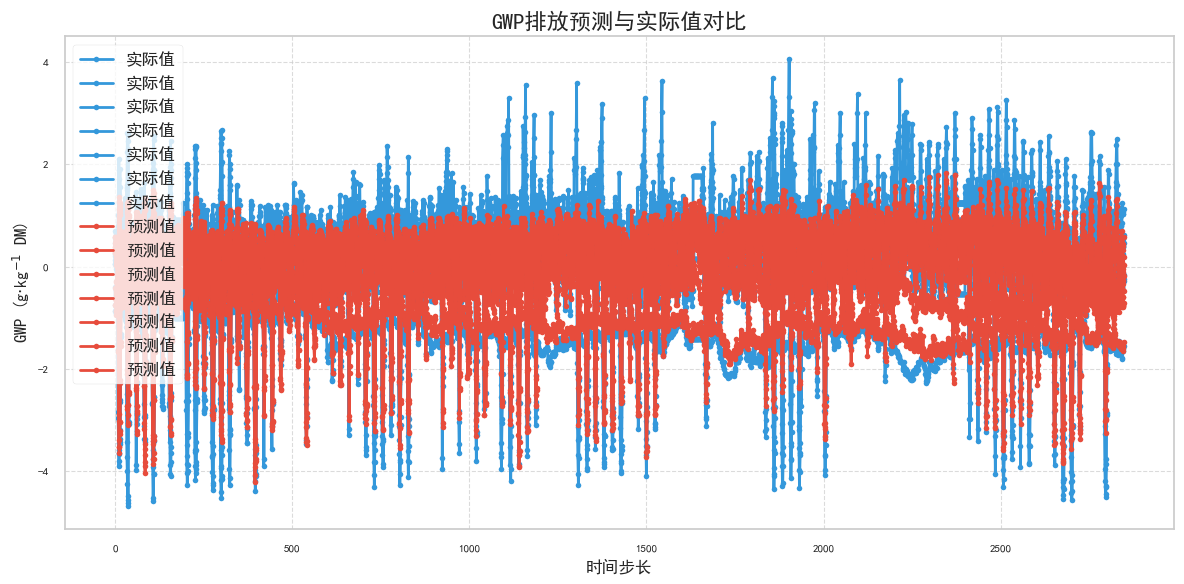

In [77]:
# 修复中文字体问题
import matplotlib as mpl
import matplotlib.font_manager as fm

# 尝试多种可能的中文字体
chinese_fonts = ['SimHei', 'Microsoft YaHei', 'SimSun', 'FangSong', 'KaiTi', 'STKaiti']
found_font = False

for font in chinese_fonts:
    try:
        # 检查字体是否可用
        if any([f.name == font for f in fm.fontManager.ttflist]):
            plt.rcParams['font.sans-serif'] = [font]
            print(f"使用中文字体：{font}")
            found_font = True
            break
    except:
        continue

if not found_font:
    # 如果没有合适的中文字体，使用默认字体并在图表中避免使用中文
    print("警告：未找到合适的中文字体，将使用英文标签")
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    
plt.rcParams['axes.unicode_minus'] = False
# 确保关闭usetex
plt.rcParams['text.usetex'] = False

# 如果成功加载了true_data和pred_data，继续处理
if true_data is not None and pred_data is not None:
    # 将数据转换为可处理的格式
    if len(true_data.shape) > 1:
        if true_data.shape[1] == 1:  # 如果只有一列
            true_values = true_data.flatten()
            pred_values = pred_data.flatten()
        else:  # 如果有多列，先取第一列
            true_values = true_data[:, 0]
            pred_values = pred_data[:, 0]
            print(f"注意: 数据有多列，仅使用第一列进行可视化")
    else:
        true_values = true_data
        pred_values = pred_data
    
    # 检查数据长度是否一致
    if len(true_values) != len(pred_values):
        print(f"警告: true_values和pred_values长度不一致，true: {len(true_values)}, pred: {len(pred_values)}")
        # 裁剪到最小长度
        min_len = min(len(true_values), len(pred_values))
        true_values = true_values[:min_len]
        pred_values = pred_values[:min_len]
    
    # 计算评估指标
    mse = mean_squared_error(true_values, pred_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, pred_values)
    r2 = r2_score(true_values, pred_values)
    
    print(f"\n计算的评估指标:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # 创建时间序列图
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, 'o-', label='实际值', color='#3498db', linewidth=2, markersize=4)
    plt.plot(pred_values, 'o-', label='预测值', color='#e74c3c', linewidth=2, markersize=4)
    plt.title('GWP排放预测与实际值对比', fontsize=16)
    plt.xlabel('时间步长', fontsize=12)
    # 使用数学文本渲染而不是直接使用Unicode
    plt.ylabel('GWP (g$\\cdot$kg$^{-1}$ DM)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("无法继续分析，请检查文件路径和格式。")

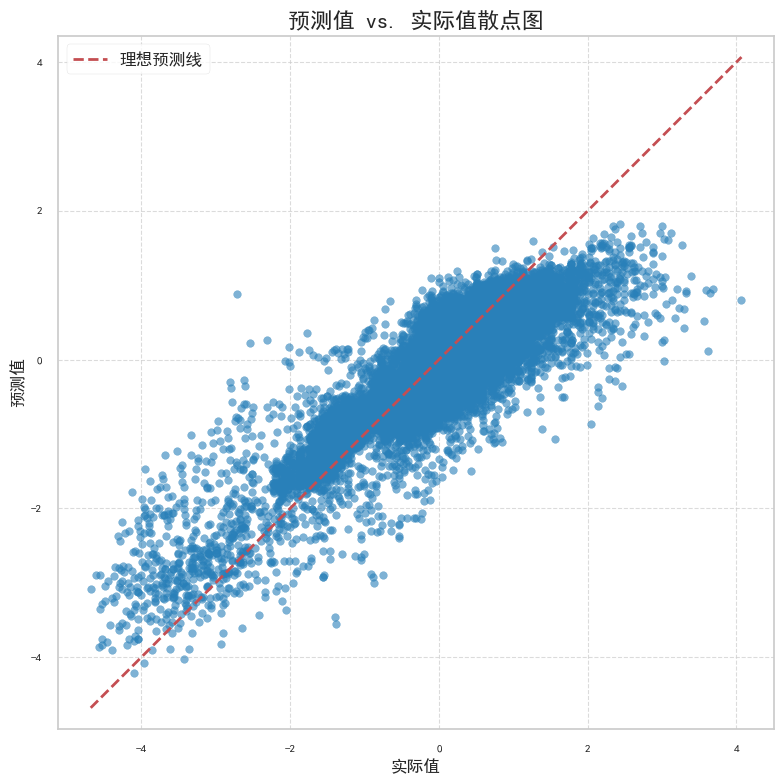

In [81]:
# 修复散点图 - 预测值与实际值对比
plt.figure(figsize=(8, 8))
plt.scatter(true_values, pred_values, alpha=0.6, color='#2980b9')

# 使用 np.min 和 np.max 而不是 min 和 max
plt.plot([np.min(true_values), np.max(true_values)], 
         [np.min(true_values), np.max(true_values)], 
         'r--', linewidth=2, label='理想预测线')

plt.title('预测值 vs. 实际值散点图', fontsize=16)
plt.xlabel('实际值', fontsize=12)
plt.ylabel('预测值', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.tight_layout()
plt.show()

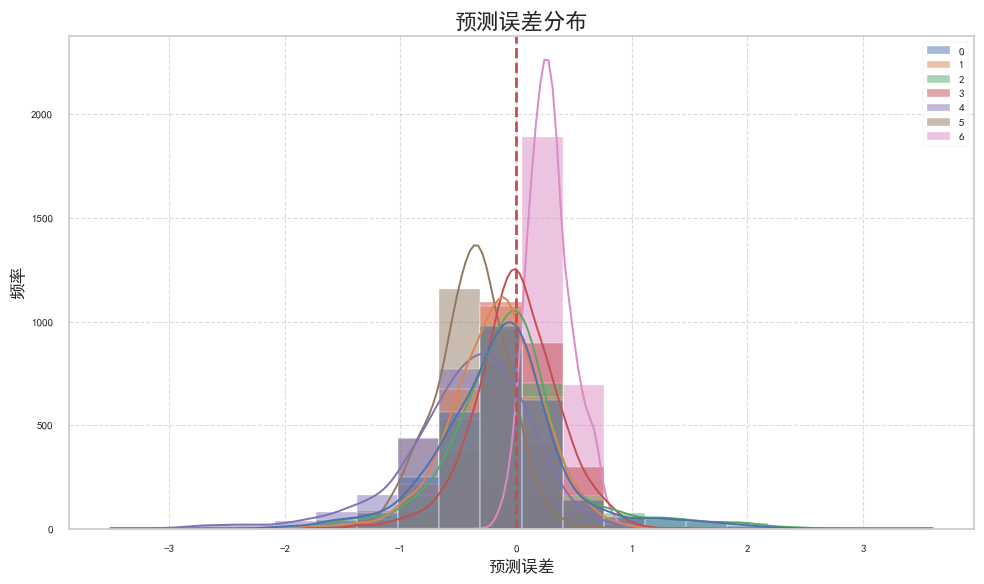

In [83]:
# 误差分布图
errors = pred_values - true_values
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='#8e44ad', bins=20)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.title('预测误差分布', fontsize=16)
plt.xlabel('预测误差', fontsize=12)
plt.ylabel('频率', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

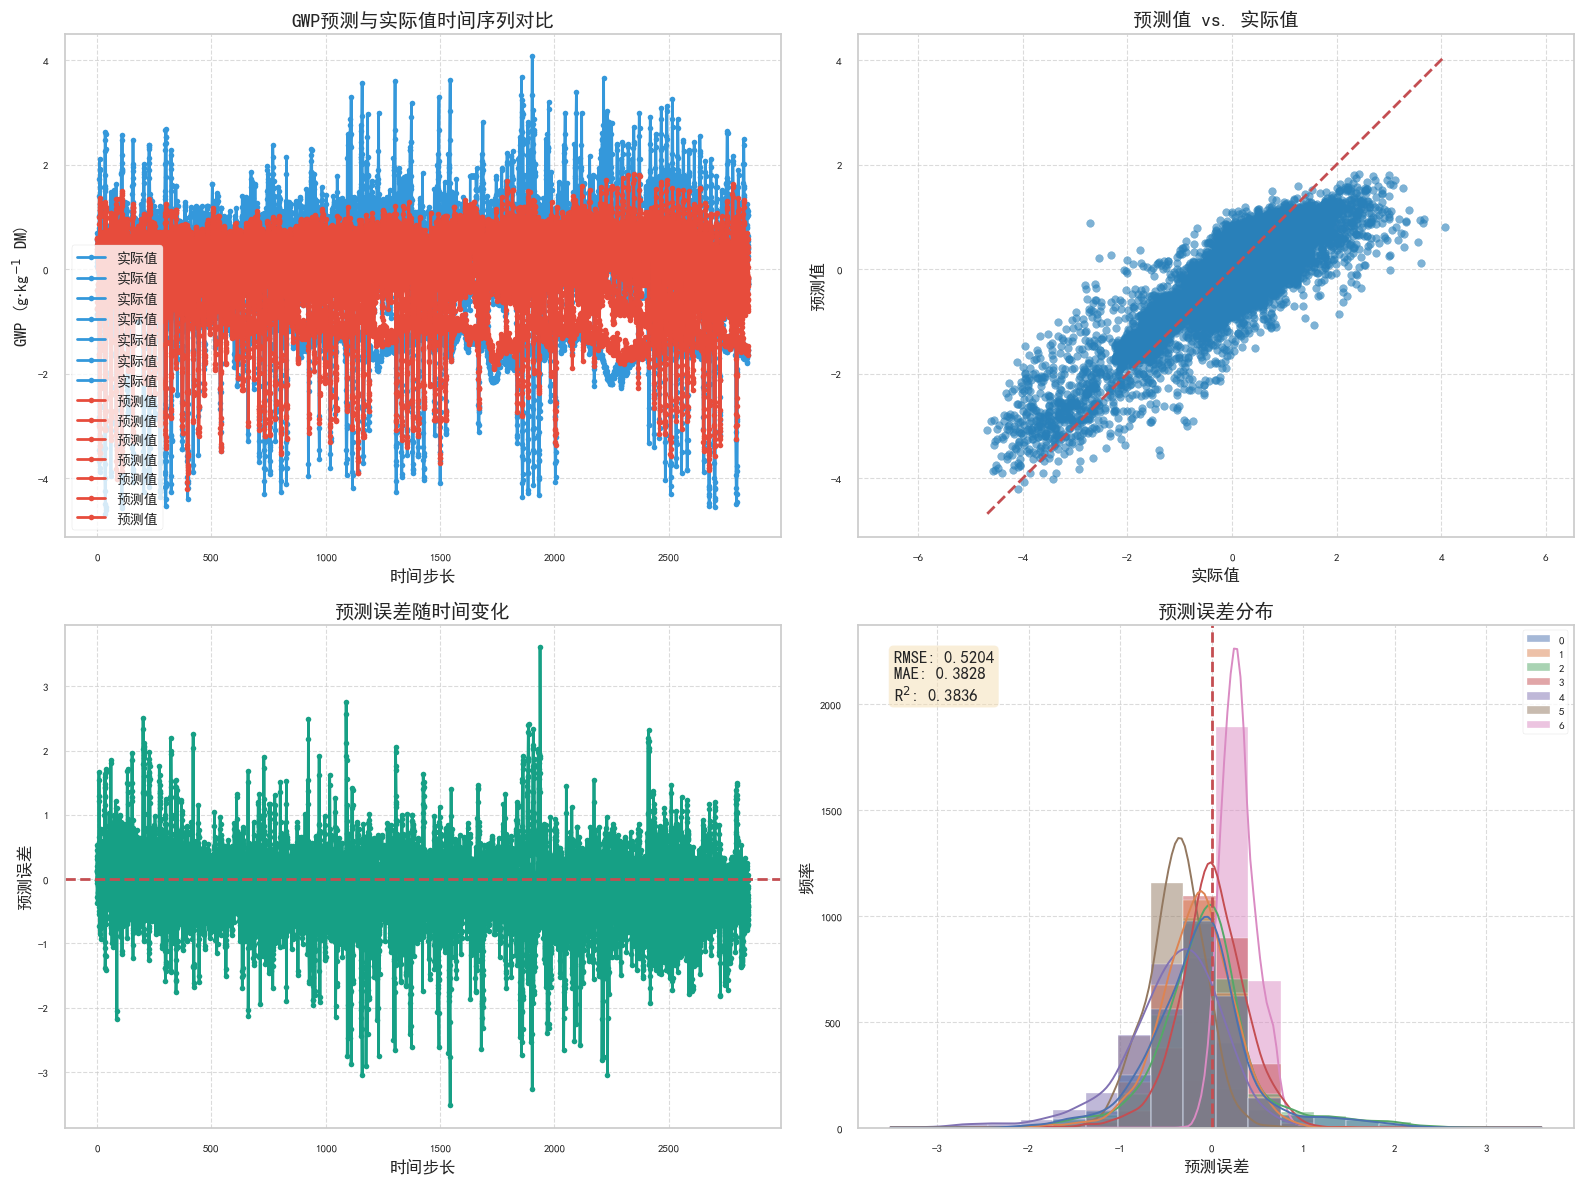

In [87]:
# 组合图表：预测性能概览
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 时间序列比较
axes[0, 0].plot(true_values, 'o-', label='实际值', color='#3498db', linewidth=2, markersize=4)
axes[0, 0].plot(pred_values, 'o-', label='预测值', color='#e74c3c', linewidth=2, markersize=4)
axes[0, 0].set_title('GWP预测与实际值时间序列对比', fontsize=14)
axes[0, 0].set_xlabel('时间步长', fontsize=12)
axes[0, 0].set_ylabel('GWP (g$\\cdot$kg$^{-1}$ DM)', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# 2. 预测 vs 实际散点图
axes[0, 1].scatter(true_values, pred_values, alpha=0.6, color='#2980b9')
min_val = min(np.min(true_values), np.min(pred_values))  # 使用np.min
max_val = max(np.max(true_values), np.max(pred_values))  # 使用np.max
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0, 1].set_title('预测值 vs. 实际值', fontsize=14)
axes[0, 1].set_xlabel('实际值', fontsize=12)
axes[0, 1].set_ylabel('预测值', fontsize=12)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].axis('equal')

# 3. 误差随时间变化
errors = pred_values - true_values  # 确保errors也被正确计算
axes[1, 0].plot(errors, 'o-', color='#16a085', linewidth=2, markersize=4)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('预测误差随时间变化', fontsize=14)
axes[1, 0].set_xlabel('时间步长', fontsize=12)
axes[1, 0].set_ylabel('预测误差', fontsize=12)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)

# 4. 误差分布
sns.histplot(errors, kde=True, color='#8e44ad', bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('预测误差分布', fontsize=14)
axes[1, 1].set_xlabel('预测误差', fontsize=12)
axes[1, 1].set_ylabel('频率', fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)  # 修复了此行的缩进问题

# 添加性能指标文本（使用数学模式解决R²字符问题）
textstr = f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR$^2$: {r2:.4f}'  # 修改为R$^2$
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axes[1, 1].text(0.05, 0.95, textstr, transform=axes[1, 1].transAxes, 
             verticalalignment='top', bbox=props, fontsize=12)

plt.tight_layout()
plt.show()

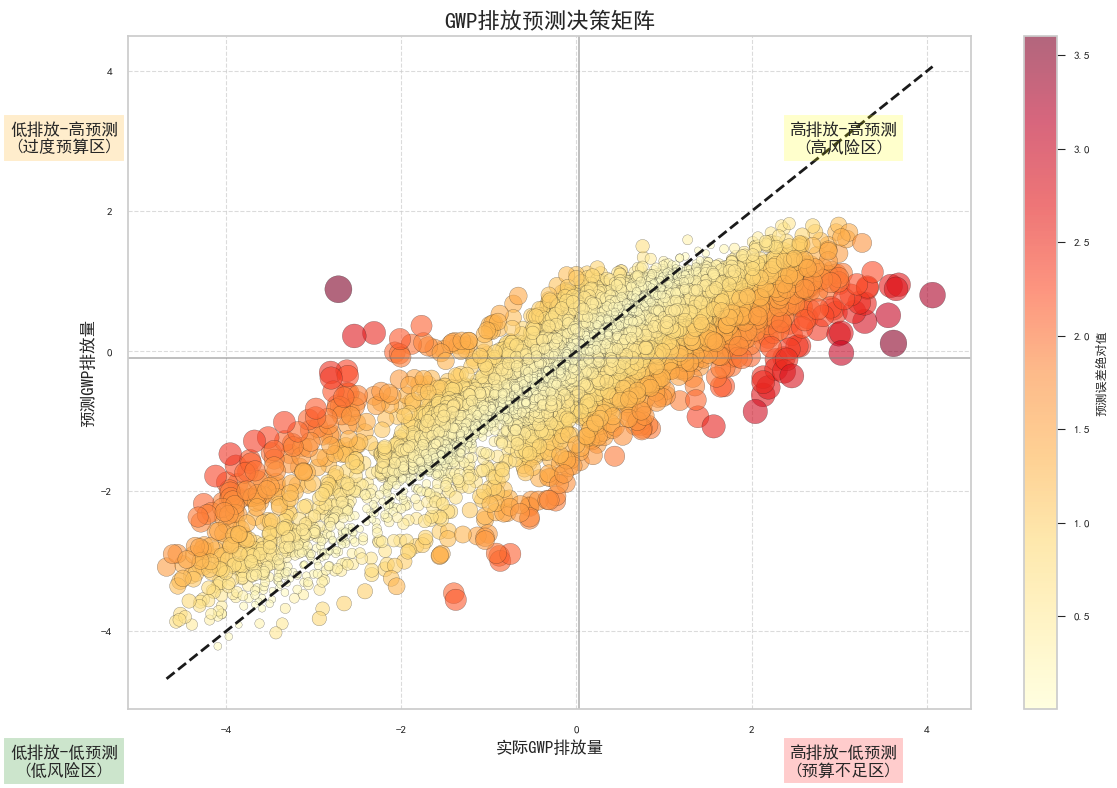

In [89]:
# 创建成本管理决策矩阵图
plt.figure(figsize=(12, 8))
# 使用预测误差的绝对值和实际值创建散点图
errors = pred_values - true_values  # 确保errors被正确计算
sizes = np.abs(errors) * 100 + 20  # 调整点的大小

# 计算最小值和最大值（使用np函数）
min_val = min(np.min(true_values), np.min(pred_values))
max_val = max(np.max(true_values), np.max(pred_values))

scatter = plt.scatter(true_values, pred_values, s=sizes, alpha=0.6, c=np.abs(errors), 
           cmap='YlOrRd', edgecolors='k')

plt.colorbar(scatter, label='预测误差绝对值')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# 添加区域标注
plt.axvline(x=np.mean(true_values), color='gray', linestyle='-', alpha=0.5)
plt.axhline(y=np.mean(pred_values), color='gray', linestyle='-', alpha=0.5)

# 添加象限标签
plt.text(max_val*0.75, max_val*0.75, '高排放-高预测\n(高风险区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.2))
plt.text(min_val*1.25, max_val*0.75, '低排放-高预测\n(过度预算区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='orange', alpha=0.2))
plt.text(max_val*0.75, min_val*1.25, '高排放-低预测\n(预算不足区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='red', alpha=0.2))
plt.text(min_val*1.25, min_val*1.25, '低排放-低预测\n(低风险区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))

plt.title('GWP排放预测决策矩阵', fontsize=16)
plt.xlabel('实际GWP排放量', fontsize=12)
plt.ylabel('预测GWP排放量', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

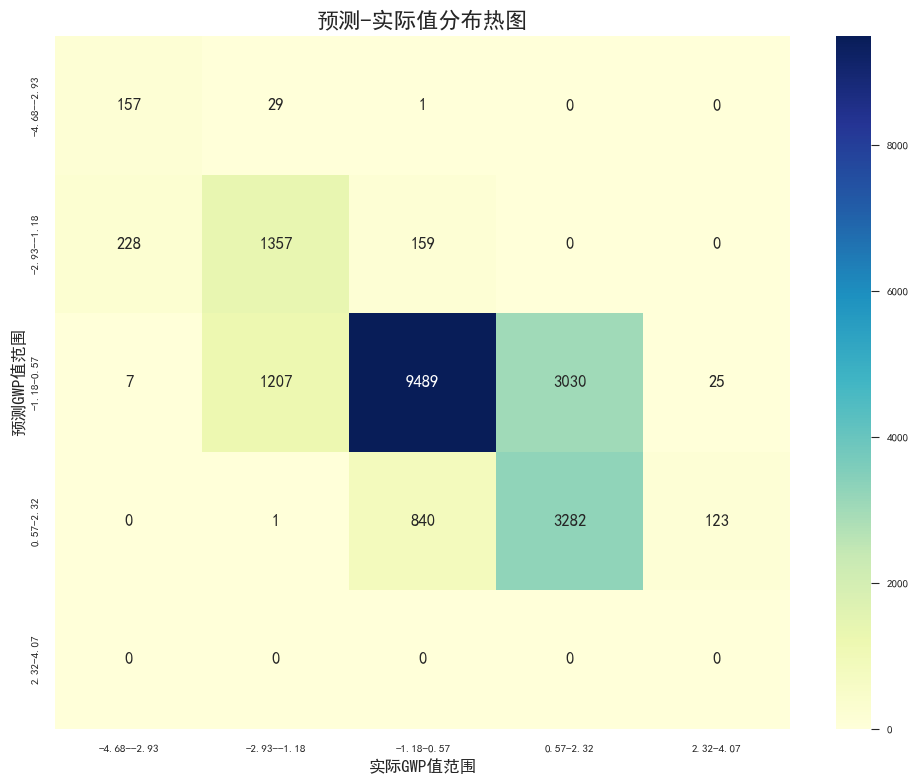

In [91]:
# 创建预测准确性区间热图
# 将数据按预测值和实际值的大小分箱
bins = 5
x_bins = np.linspace(min_val, max_val, bins+1)
y_bins = np.linspace(min_val, max_val, bins+1)

# 创建热图矩阵
heatmap_matrix = np.zeros((bins, bins))
for i in range(bins):
    for j in range(bins):
        # 找出落在当前bin中的点
        mask = (true_values >= x_bins[i]) & (true_values < x_bins[i+1]) & \
               (pred_values >= y_bins[j]) & (pred_values < y_bins[j+1])
        heatmap_matrix[j, i] = np.sum(mask)  # 注意：热图通常是[y,x]索引

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, annot=True, fmt=".0f", cmap="YlGnBu", 
            xticklabels=[f"{x_bins[i]:.2f}-{x_bins[i+1]:.2f}" for i in range(bins)],
            yticklabels=[f"{y_bins[i]:.2f}-{y_bins[i+1]:.2f}" for i in range(bins)])
plt.xlabel('实际GWP值范围', fontsize=12)
plt.ylabel('预测GWP值范围', fontsize=12)
plt.title('预测-实际值分布热图', fontsize=16)
plt.tight_layout()
plt.show()

In [95]:
# 辅助函数：确保数据是一维的
def ensure_1d(arr):
    """确保数组是一维的，如果不是则将其展平"""
    if hasattr(arr, 'ndim') and arr.ndim > 1:
        print(f"警告：将形状为 {arr.shape} 的数组展平为一维")
        return arr.reshape(-1)
    return arr

# 处理数据
true_values_1d = ensure_1d(true_values)
pred_values_1d = ensure_1d(pred_values)
errors = pred_values_1d - true_values_1d

print("处理后数据形状:")
print("true_values_1d形状:", true_values_1d.shape)
print("pred_values_1d形状:", pred_values_1d.shape)

警告：将形状为 (2848, 7) 的数组展平为一维
警告：将形状为 (2848, 7) 的数组展平为一维
处理后数据形状:
true_values_1d形状: (19936,)
pred_values_1d形状: (19936,)


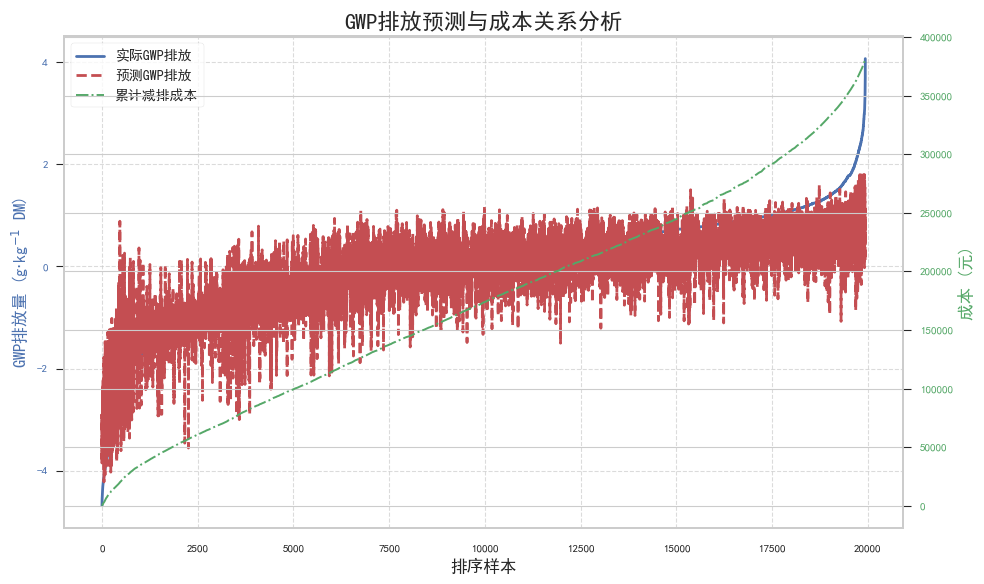

In [97]:
# 创建一个决策支持图 - 修复多维数组问题
fig = plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# 排序
indices = np.argsort(true_values_1d)
x = np.arange(len(indices))
sorted_true = true_values_1d[indices]
sorted_pred = pred_values_1d[indices]

# 绘制图形
ax1.plot(x, sorted_true, 'b-', label='实际GWP排放', linewidth=2)
ax1.plot(x, sorted_pred, 'r--', label='预测GWP排放', linewidth=2)
ax1.set_xlabel('排序样本', fontsize=12)
ax1.set_ylabel('GWP排放量 (g$\\cdot$kg$^{-1}$ DM)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, linestyle='--', alpha=0.7)

# 添加成本曲线（模拟数据）
estimated_cost_per_unit = 50  # 每单位GWP减排的成本（示例值）
ax2 = ax1.twinx()
cost_curve = np.cumsum(np.abs(sorted_pred - sorted_true) * estimated_cost_per_unit)
ax2.plot(x, cost_curve, 'g-.', label='累计减排成本')
ax2.set_ylabel('成本 (元)', color='g', fontsize=12)
ax2.tick_params(axis='y', labelcolor='g')

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('GWP排放预测与成本关系分析', fontsize=16)
plt.tight_layout()
plt.show()

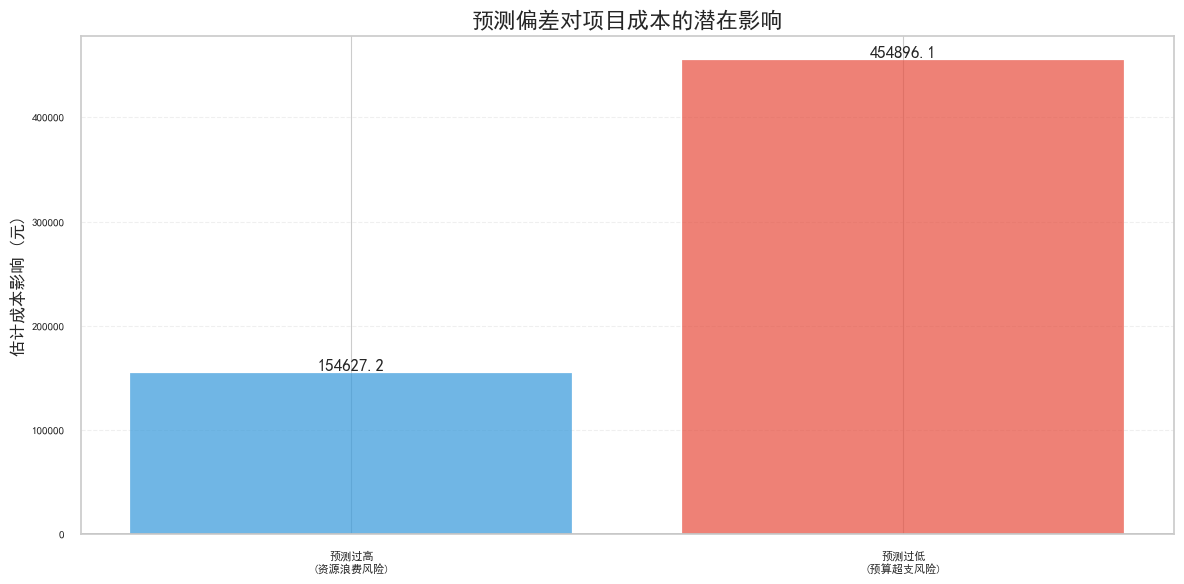

In [99]:
# 预测偏差分析图 (正/负偏差对成本的不同影响)
plt.figure(figsize=(12, 6))

# 按偏差大小分组
positive_errors = errors[errors > 0]
negative_errors = errors[errors < 0]

# 假设正偏差(预测>实际)和负偏差(预测<实际)对成本有不同影响
positive_cost_factor = 1.2  # 过度预估的成本因子
negative_cost_factor = 1.8  # 低估的成本因子

# 计算成本影响
positive_impact = np.sum(positive_errors * estimated_cost_per_unit * positive_cost_factor)
negative_impact = np.sum(np.abs(negative_errors) * estimated_cost_per_unit * negative_cost_factor)

# 绘制柱状图
x = ['预测过高\n(资源浪费风险)', '预测过低\n(预算超支风险)']
y = [positive_impact, negative_impact]
colors = ['#3498db', '#e74c3c']

bars = plt.bar(x, y, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height+0.1,
             f'{height:.1f}', ha='center', va='bottom')

plt.title('预测偏差对项目成本的潜在影响', fontsize=16)
plt.ylabel('估计成本影响 (元)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

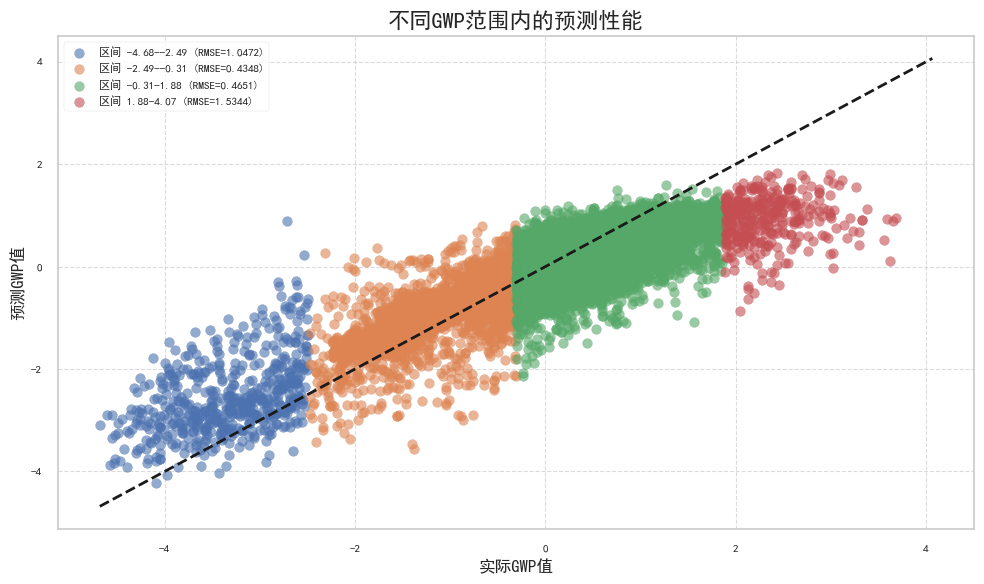

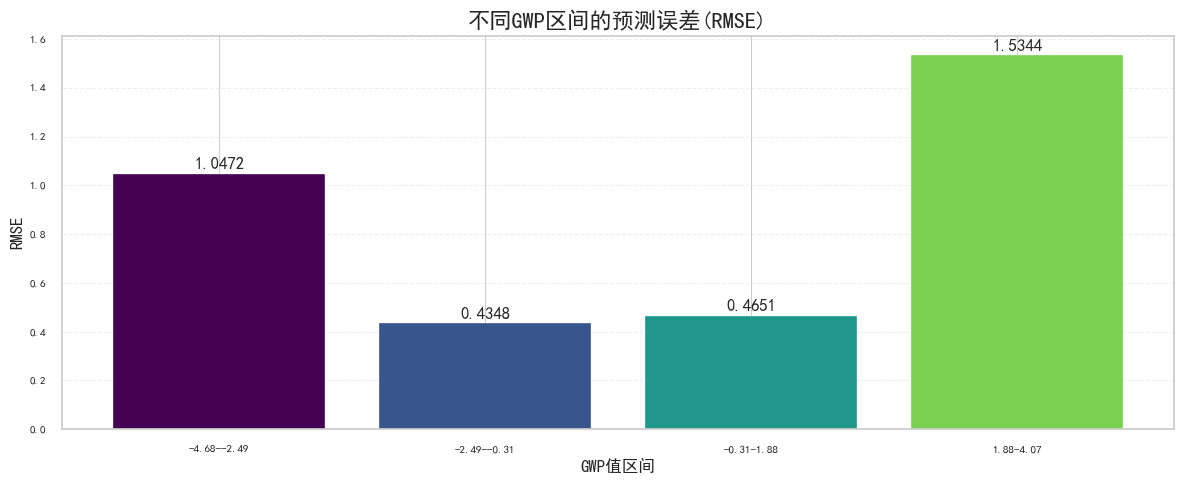

In [101]:
# 不同预测范围内的模型性能分析
# 将实际值分为几个区间并计算每个区间的RMSE
n_segments = 4
min_val = np.min(true_values_1d)
max_val = np.max(true_values_1d)
segment_edges = np.linspace(min_val, max_val, n_segments+1)
segment_rmse = []
segment_labels = []

plt.figure(figsize=(10, 6))

for i in range(n_segments):
    mask = (true_values_1d >= segment_edges[i]) & (true_values_1d < segment_edges[i+1])
    if np.sum(mask) > 0:  # 确保该区间有数据点
        segment_true = true_values_1d[mask]
        segment_pred = pred_values_1d[mask]
        seg_rmse = np.sqrt(mean_squared_error(segment_true, segment_pred))
        segment_rmse.append(seg_rmse)
        label = f'{segment_edges[i]:.2f}-{segment_edges[i+1]:.2f}'
        segment_labels.append(label)
        
        # 添加散点图
        plt.scatter(segment_true, segment_pred, 
                    label=f'区间 {label} (RMSE={seg_rmse:.4f})', 
                    alpha=0.6, s=50)

plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)
plt.title('不同GWP范围内的预测性能', fontsize=16)
plt.xlabel('实际GWP值', fontsize=12)
plt.ylabel('预测GWP值', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 不同区间的RMSE条形图
plt.figure(figsize=(12, 5))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(segment_rmse)))
bars = plt.bar(segment_labels, segment_rmse, color=colors)

# 添加数据标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height+0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('不同GWP区间的预测误差(RMSE)', fontsize=16)
plt.xlabel('GWP值区间', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [103]:
# 重新计算评估指标（确保使用一维数据）
mse = mean_squared_error(true_values_1d, pred_values_1d)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_1d, pred_values_1d)
r2 = r2_score(true_values_1d, pred_values_1d)

# 创建性能评估表格
metrics_df = pd.DataFrame({
    '评估指标': ['RMSE', 'MAE', 'R$^2$'],  # 使用数学模式表示R²
    '值': [rmse, mae, r2]
})

print("\n性能评估表格:")
display(metrics_df)

# 创建不同区间性能表格
segments_df = pd.DataFrame({
    'GWP值区间': segment_labels,
    'RMSE': segment_rmse,
    '数据点数量': [np.sum((true_values_1d >= segment_edges[i]) & 
                    (true_values_1d < segment_edges[i+1])) 
                for i in range(n_segments)]
})

print("\n不同区间性能表格:")
display(segments_df)


性能评估表格:


,评估指标,值
0,RMSE,0.520381
1,MAE,0.382801
2,R$^2$,0.756299



不同区间性能表格:


,GWP值区间,RMSE,数据点数量
0,-4.68--2.49,1.047166,559
1,-2.49--0.31,0.434821,5009
2,-0.31-1.88,0.465062,14030
3,1.88-4.07,1.534426,337


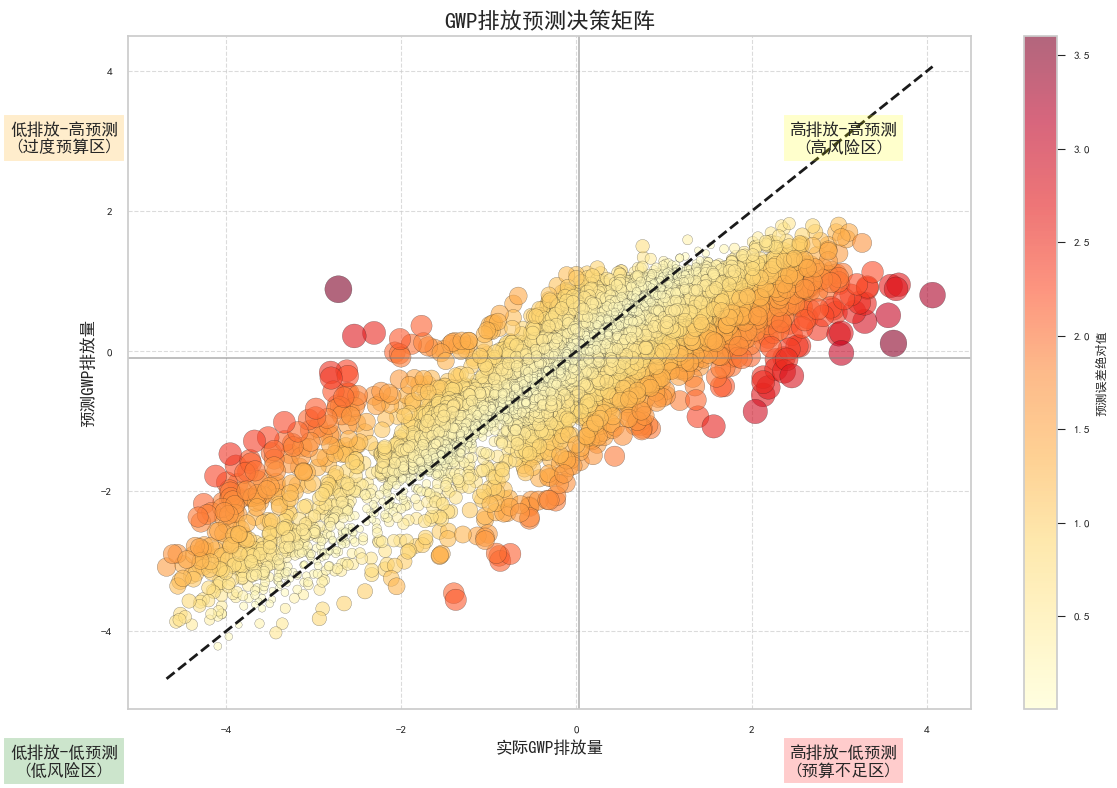

In [105]:
# 创建成本管理决策矩阵图
plt.figure(figsize=(12, 8))
# 使用预测误差的绝对值和实际值创建散点图
sizes = np.abs(errors) * 100 + 20  # 调整点的大小

# 计算最小值和最大值
min_val = min(np.min(true_values_1d), np.min(pred_values_1d))
max_val = max(np.max(true_values_1d), np.max(pred_values_1d))

scatter = plt.scatter(true_values_1d, pred_values_1d, s=sizes, alpha=0.6, c=np.abs(errors), 
           cmap='YlOrRd', edgecolors='k')

plt.colorbar(scatter, label='预测误差绝对值')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# 添加区域标注
plt.axvline(x=np.mean(true_values_1d), color='gray', linestyle='-', alpha=0.5)
plt.axhline(y=np.mean(pred_values_1d), color='gray', linestyle='-', alpha=0.5)

# 添加象限标签
plt.text(max_val*0.75, max_val*0.75, '高排放-高预测\n(高风险区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.2))
plt.text(min_val*1.25, max_val*0.75, '低排放-高预测\n(过度预算区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='orange', alpha=0.2))
plt.text(max_val*0.75, min_val*1.25, '高排放-低预测\n(预算不足区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='red', alpha=0.2))
plt.text(min_val*1.25, min_val*1.25, '低排放-低预测\n(低风险区)', 
         ha='center', va='center', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))

plt.title('GWP排放预测决策矩阵', fontsize=16)
plt.xlabel('实际GWP排放量', fontsize=12)
plt.ylabel('预测GWP排放量', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

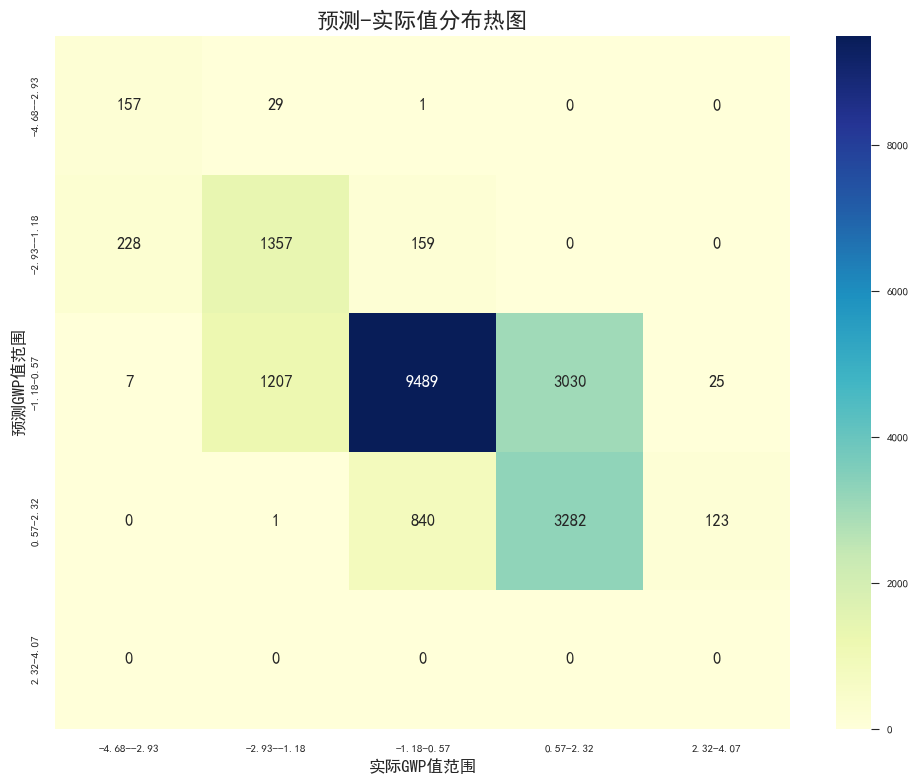

In [107]:
# 创建预测准确性区间热图
# 将数据按预测值和实际值的大小分箱
bins = 5
x_bins = np.linspace(min_val, max_val, bins+1)
y_bins = np.linspace(min_val, max_val, bins+1)

# 创建热图矩阵
heatmap_matrix = np.zeros((bins, bins))
for i in range(bins):
    for j in range(bins):
        # 找出落在当前bin中的点
        mask = (true_values_1d >= x_bins[i]) & (true_values_1d < x_bins[i+1]) & \
               (pred_values_1d >= y_bins[j]) & (pred_values_1d < y_bins[j+1])
        heatmap_matrix[j, i] = np.sum(mask)  # 注意：热图通常是[y,x]索引

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, annot=True, fmt=".0f", cmap="YlGnBu", 
            xticklabels=[f"{x_bins[i]:.2f}-{x_bins[i+1]:.2f}" for i in range(bins)],
            yticklabels=[f"{y_bins[i]:.2f}-{y_bins[i+1]:.2f}" for i in range(bins)])
plt.xlabel('实际GWP值范围', fontsize=12)
plt.ylabel('预测GWP值范围', fontsize=12)
plt.title('预测-实际值分布热图', fontsize=16)
plt.tight_layout()
plt.show()

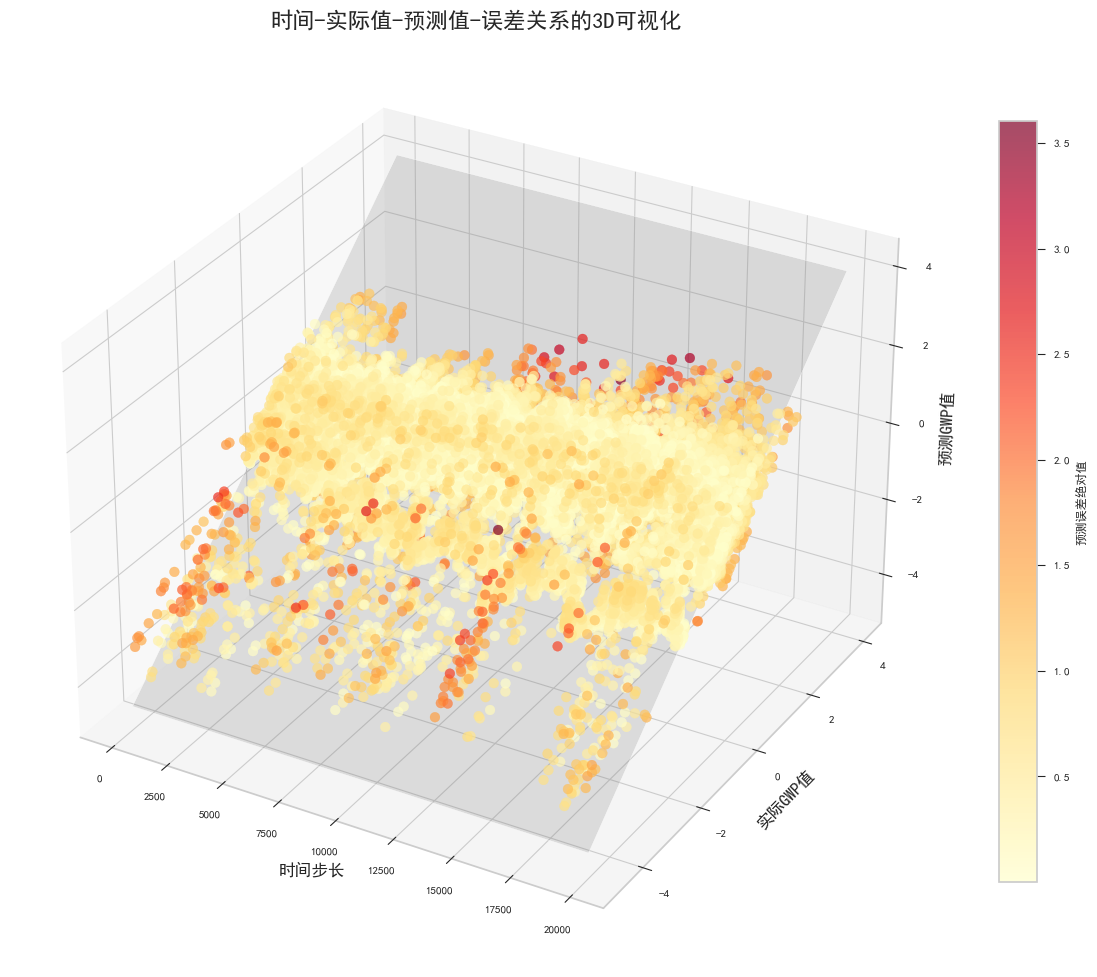

In [109]:
# 创建3D可视化 - 时间、预测值和误差的关系
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 获取时间点、预测值和误差
time_points = np.arange(len(true_values_1d))
abs_errors = np.abs(errors)

# 创建散点图，使用误差的绝对值作为颜色映射
scatter = ax.scatter(time_points, true_values_1d, pred_values_1d, 
                    c=abs_errors, cmap='YlOrRd', 
                    s=50, alpha=0.7)

# 添加辅助元素
ax.set_xlabel('时间步长', fontsize=12)
ax.set_ylabel('实际GWP值', fontsize=12)
ax.set_zlabel('预测GWP值', fontsize=12)
ax.set_title('时间-实际值-预测值-误差关系的3D可视化', fontsize=16)

# 添加颜色条，显示误差大小
cbar = fig.colorbar(scatter, ax=ax, shrink=0.8, aspect=20)
cbar.set_label('预测误差绝对值')

# 添加理想预测平面的参考
# 创建一个表面网格
x_surf = np.linspace(np.min(time_points), np.max(time_points), 2)
y_surf = np.linspace(np.min(true_values_1d), np.max(true_values_1d), 2)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
z_surf = y_surf.copy()  # 理想情况下，z(预测值) = y(实际值)

ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.2, color='gray')

plt.tight_layout()
plt.show()